In [1]:
from sklearn import metrics
import numpy as np
import torch
import argparse
from collections import namedtuple
# import wandb
import os

from matplotlib import pyplot as plt

import change_detection_pytorch as cdp
from change_detection_pytorch.datasets import LEVIR_CD_Dataset
from torch.utils.data import DataLoader

# from change_detection_pytorch.utils.lr_scheduler import GradualWarmupScheduler

from change_detection_pytorch.datasets import ChangeDetectionDataModule
from argparse import ArgumentParser
from tqdm import tqdm

In [2]:
checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_oscd192_diff_e_real_160_b32_multisteplr/best_model.pth'
# checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/debug_polylr/best_model.pth'
# checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_oscd192_e160_b32_concat/best_model.pth'
# checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/ibot_mid_oscd192_diff_e_160_multisteplr/best_model.pth'
checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_polylr_e200_lr2e-4/best_model.pth'
checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_cdd/best_model.pth'
checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/gfm/best_model.pth'
checkpoint_path = '/auto/home/ani/change_detection.pytorch/checkpoints/gfm_aug/best_model.pth'



In [3]:
  Args = namedtuple('Args', ['experiment_name', 'backbone', 'encoder_weights', 'encoder_depth',
                             'dataset_name', 'dataset_path', 'fusion', 'scale',
                             'tile_size', 'mode', 'batch_size'])

In [4]:
  args = Args(experiment_name='tmp', fusion='diff', tile_size=192,
              backbone='Swin-B', encoder_weights='geopile', encoder_depth=12,
              dataset_name='OSCD', dataset_path='/mnt/sxtn/aerial/change/OSCD/', batch_size=116//4,
              # mode='vanilla', scale=None,
              mode='wo_train_aug', scale='4x'
             )

In [5]:
  # args = Args(experiment_name='tmp', fusion='diff', tile_size=192,
  #             backbone='Swin-B', encoder_weights='geopile', encoder_depth=5,
  #             dataset_name='CDD', dataset_path='/mnt/sxtn/aerial/change/CDD/Real/subset/', batch_size=2,
  #             mode='vanilla', scale=None,
  #             # mode='wo_train_aug', scale='8x'
  #            )

In [6]:
  # args = Args(experiment_name='tmp', fusion='diff', tile_size=192, 
  #             backbone='ibot-B', encoder_weights='million_aid', encoder_depth=12,
  #             dataset_name='OSCD', dataset_path='/mnt/sxtn/aerial/change/OSCD/', batch_size=116//4,
  #             # mode='vanilla', scale=None,
  #             mode='wo_train_aug', scale='8x'
  #            )

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = cdp.UPerNet(
    encoder_depth=args.encoder_depth,
    encoder_name=args.backbone, # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=args.encoder_weights, # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3, # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2, # model output channels (number of classes in your datasets)
    siam_encoder=True, # whether to use a siamese encoder
    fusion_form=args.fusion, # the form of fusing features from two branches. e.g. concat, sum, diff, or abs_diff.
)

/auto/home/ani/miniforge3/envs/cd/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "/nfs/ap/mnt/sxtn/cd/gfm_model/gfm.pth" to /auto/home/ani/.cache/torch/hub/checkpoints/gfm.pth


unknown url type: '/nfs/ap/mnt/sxtn/cd/gfm_model/gfm.pth'
layers.0.blocks.0.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.0.blocks.1.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.1.blocks.0.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.1.blocks.1.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.2.blocks.0.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.2.blocks.1.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.2.blocks.2.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.2.blocks.3.attn.relative_position_bias_table: Interpolate relative_position_bias_table using geo.
layers.2.blocks.4.attn.relative_position_bias_table: Interpolate relative_position_bias_table using ge

In [8]:
checkpoint = torch.load(checkpoint_path)

In [9]:
model.load_state_dict(checkpoint.state_dict())

<All keys matched successfully>

In [10]:
if 'oscd' in args.dataset_name.lower():
    datamodule = ChangeDetectionDataModule(args.dataset_path, patch_size=args.tile_size, mode=args.mode, scale=args.scale, batch_size=args.batch_size)
    datamodule.setup()

    valid_loader = datamodule.val_dataloader()
    print(len(valid_loader))
    data = {
        'p': np.empty((0, 192, 192)),
        't': np.empty((0, 192, 192)),
        'f': []
    }
else:
    print('CCD', args.dataset_name)
    valid_dataset = LEVIR_CD_Dataset(f'{args.dataset_path}/val',
                                    sub_dir_1='A',
                                    sub_dir_2='B',
                                    img_suffix='.jpg',
                                    ann_dir=f'{args.dataset_path}/val/OUT',
                                    debug=False,
                                    seg_map_suffix='.jpg')

    valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    data = {
        'p': np.empty((0, 256, 256)),
        't': np.empty((0, 256, 256)),
        'f': []
    }
loss = cdp.utils.losses.CrossEntropyLoss()

4x
4


In [11]:
from change_detection_pytorch.base.modules import Activation
from change_detection_pytorch.utils import base
from change_detection_pytorch.utils import functional as F

class CustomMetric(base.Metric):
    __name__ = 'custom'

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        data['p'] = np.concatenate([data['p'], y_pr.cpu().numpy()])
        data['t'] = np.concatenate([data['t'], y_gt.cpu().numpy()])
        
        fscores = torch.tensor([F.f_score(p, g) for p, g in zip(y_pr, y_gt)])
        # plt.figure(figsize=(4,2))
        # plt.imshow((y_pr[0]*2+y_gt[0]).cpu().numpy(), cmap='nipy_spectral', vmax=4)
        # plt.title(f"F-score={fscores[0]:.3f}")
        # print("\n", y_pr.shape, y_gt.shape)
        # print((y_pr*y_gt).sum(), y_pr.sum(), y_gt.sum())
        return fscores.mean()

In [12]:
our_metrics = [
    cdp.utils.metrics.Fscore(activation='argmax2d'),
    cdp.utils.metrics.Precision(activation='argmax2d'),
    cdp.utils.metrics.Recall(activation='argmax2d'),
    CustomMetric(activation='argmax2d'),
]

In [13]:
valid_epoch = cdp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=our_metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = valid_epoch.run(valid_loader)


valid:   0%|                                                                                              | 0/4 [00:00<?, ?it/s]

/auto/home/ani/miniforge3/envs/cd/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


valid: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.01it/s]


In [14]:
data['f'] = [y for x in valid_logs['filenames'] for y in x]

In [15]:
cities = []
coords = []
for name in data['f']:
    name = name.split('/')[-1]
    _parts = name.split('_')
    city = '_'.join(_parts[:-1])
    coord = [int(t) for t in _parts[-1][1:-1].split(', ')]
    cities.append(city)
    coords.append(coord)

In [16]:
unique_cities = set(cities)

In [17]:
maps = {city: {
    't': np.zeros((1000, 1000)),
    'p': np.zeros((1000, 1000)),
} for city in unique_cities}

In [18]:
for city, coord, p, t in zip(cities, coords, data['p'], data['t']):
    x1,y1,x2,y2 = coord
    maps[city]['t'][y1:y2,x1:x2] = t
    maps[city]['p'][y1:y2,x1:x2] = p

In [19]:
for city in tqdm(maps.keys()):
    maps[city]['fscore'] = metrics.f1_score(maps[city]['t'].flatten(), maps[city]['p'].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


In [20]:
micro_f1 = metrics.f1_score(
    np.concatenate([maps[city]['t'].flatten() for city in maps]),
    np.concatenate([maps[city]['p'].flatten() for city in maps]), 
)

In [21]:
np.mean([maps[city]['fscore'] for city in maps]), micro_f1

(0.1822475124377157, 0.31183032842623737)

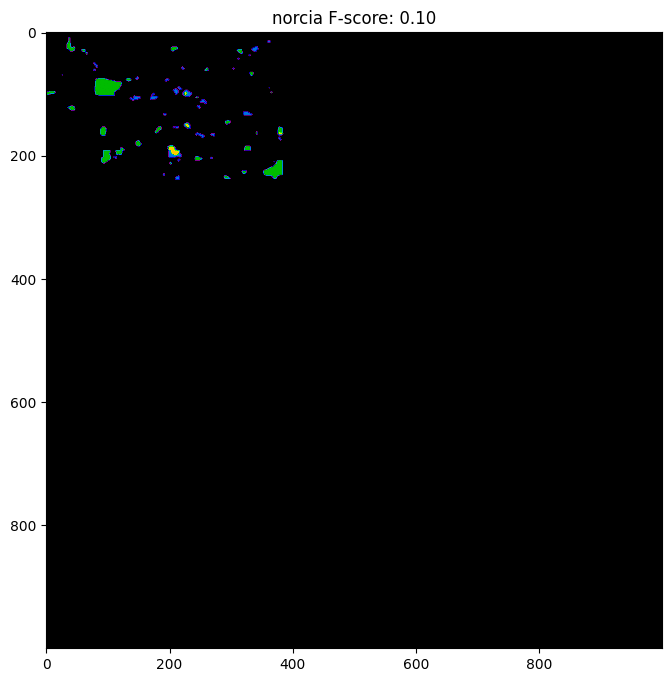

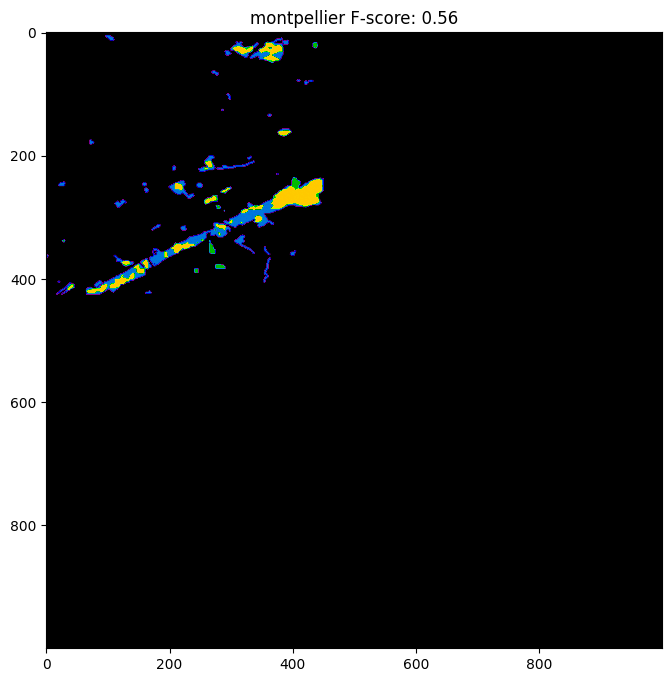

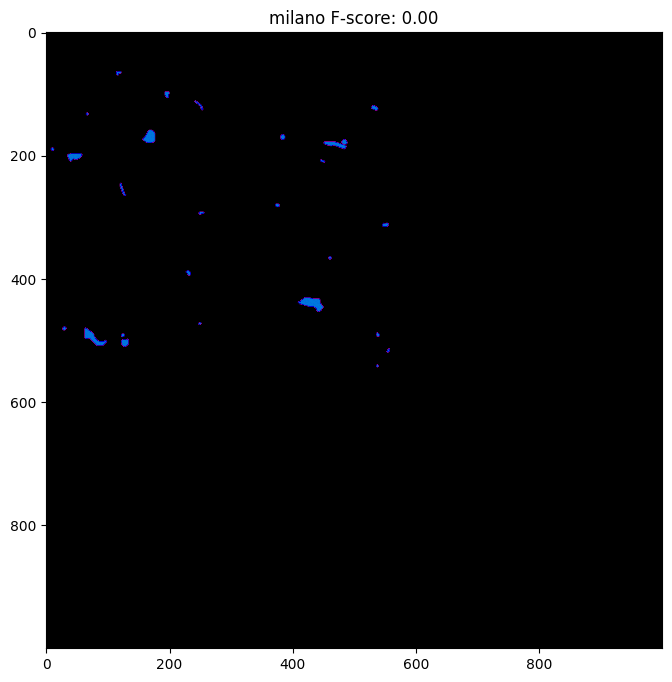

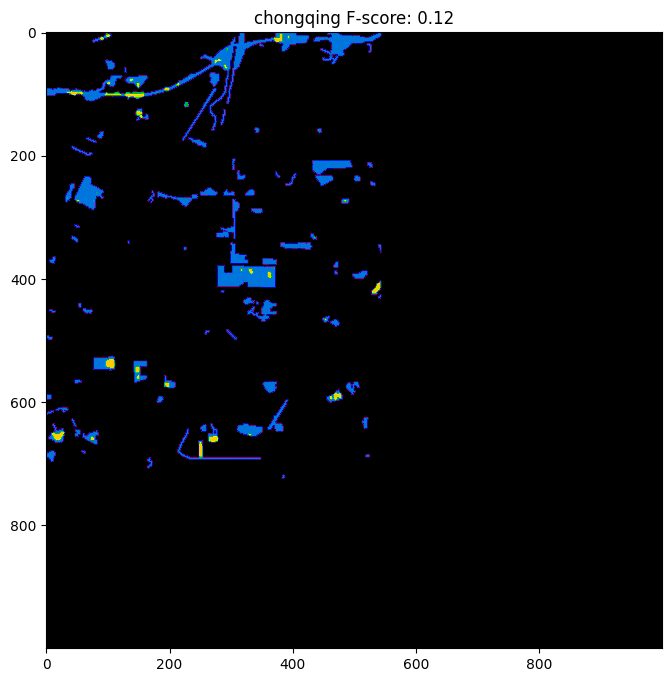

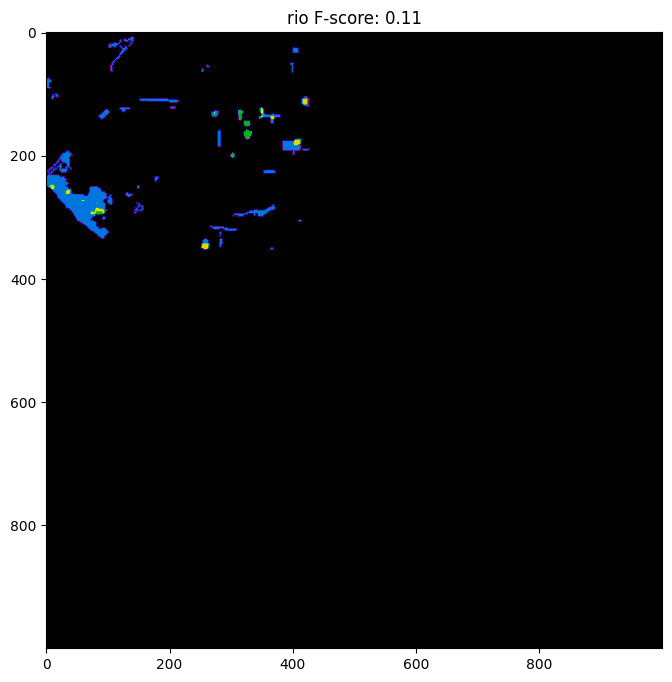

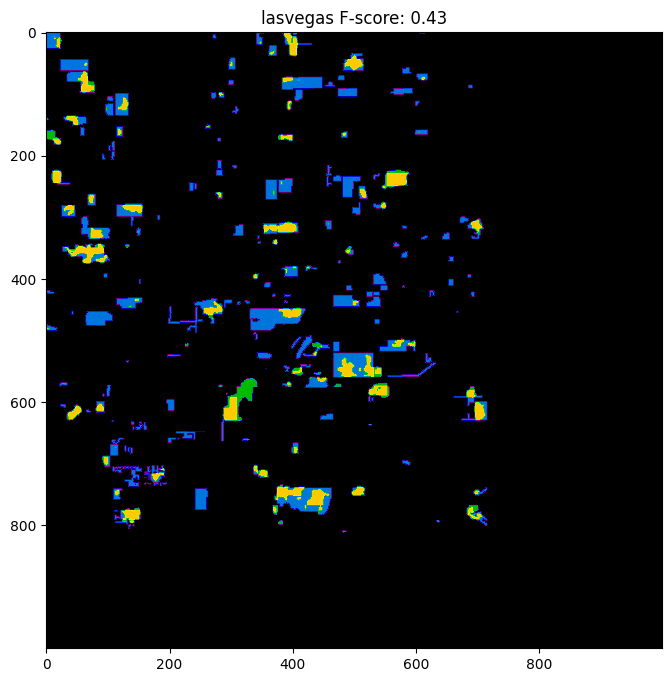

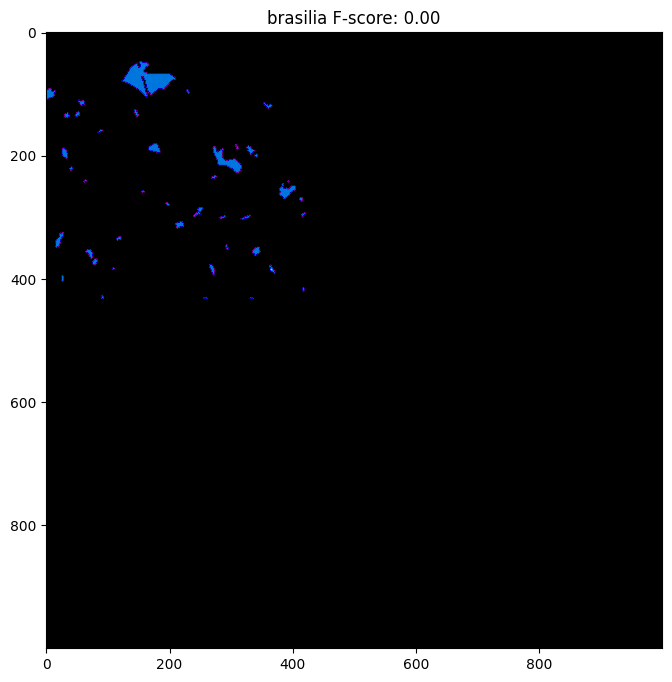

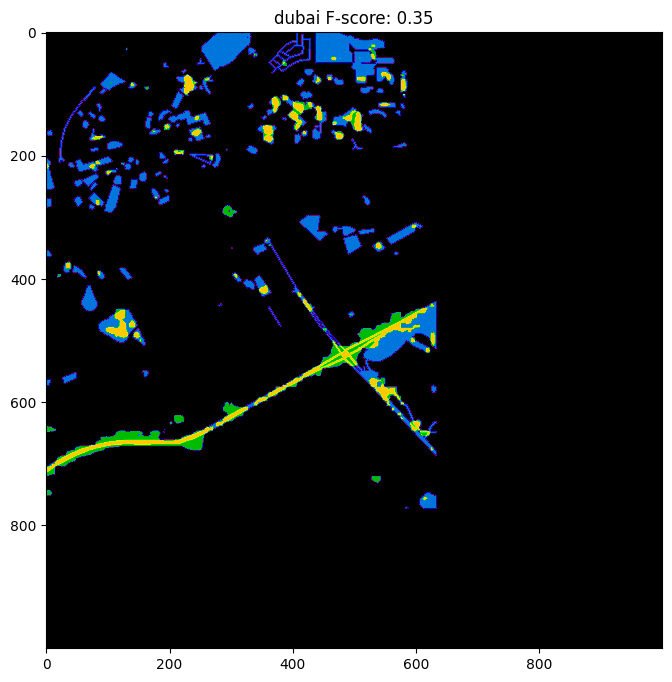

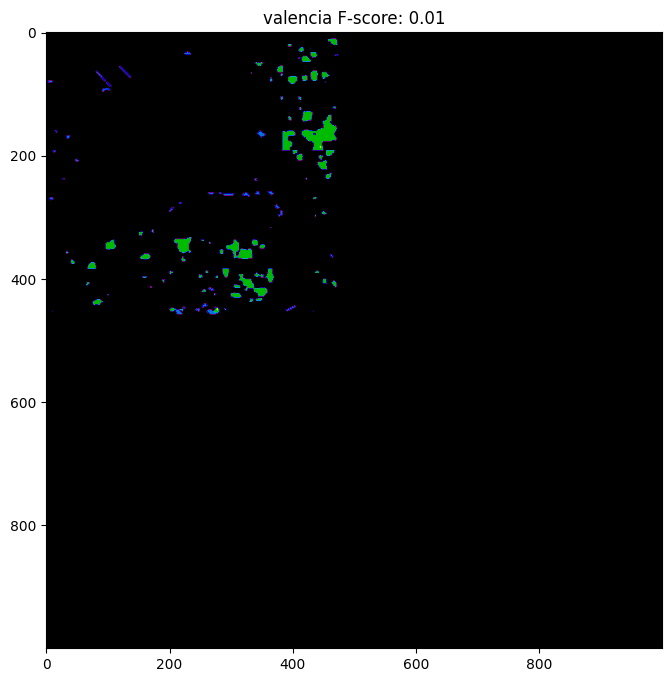

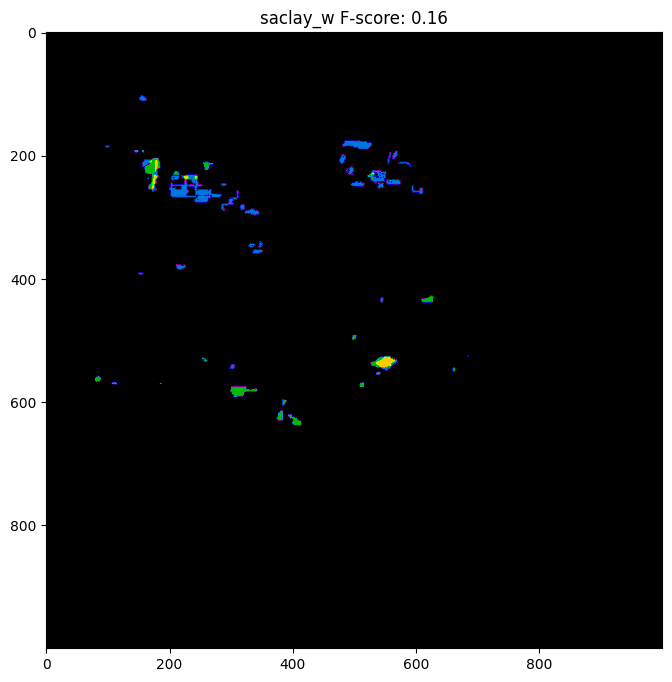

In [22]:
for city in maps.keys():
    plt.figure(figsize=(8,8))
    plt.imshow(maps[city]['p']*2 + maps[city]['t'], cmap='nipy_spectral', vmax=4)
    plt.title(f"{city} F-score: {maps[city]['fscore']:.2f}")